# Assignment 3 - Task 3

### Train a simplest possible MLP to solve the same classification problems of task 2. (25)

1. Explain rationale behind your training process and design parameters
2. Compare SVM and MLP solution in terms of computational cost
3. Apply k-Fold cross validation


Contents:

1. Import Libraries

2. Generate Datasets

3. Train Simple MLP

4. Explain Rationale

5. Compare SVM and MLP

6. Apply k-Fold cross validation

7. Conclusion

### 1. Import Libraries:

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
import time

class ModelComparison:
    def __init__(self, hidden_layer_sizes=(5,), max_iter=10000, kernels=['linear', 'rbf']):
        """
        Initialize with params for the mlp
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter
        self.kernels = kernels

    def generate_dataset(self, dataset_name='moons', **kwargs):
        """
        Generates dataset via name
        """
        if dataset_name == 'moons':
            X, y = make_moons(**kwargs)
        elif dataset_name == 'circles':
            X, y = make_circles(**kwargs)
        else:
            raise ValueError("error bad name")
        return X, y
    
    def visualize_dataset(self, X, y, dataset_name):
        """
        plots dataset
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
        plt.title(f"{dataset_name.capitalize()} Dataset")
        plt.xlabel("Feature 1")
        plt.ylabel("Featere 2")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def train_mlp(self, X, y):
        """
        train mlp on dataset and return metrics
        """
        # split up
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        mlp = MLPClassifier(hidden_layer_sizes=self.hidden_layer_sizes, max_iter=self.max_iter, random_state=1)
        
        # training time
        start_time = time.time()
        mlp.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # eval model 
        y_pred = mlp.predict(X_test)
        y_prob = mlp.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        return {"Model": "MLP", "Accuracy": accuracy, "ROC-AUC": roc_auc, "Train Time": train_time}
    
    def train_simple_mlp(self, X, y, mlp_params=None):
        """
        train simple MLP, playground to test the model with params
        """
        # split up data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        
        # create model with params
        mlp = MLPClassifier(**mlp_params)
        
        # measure training
        start_time = time.time()
        mlp.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # eval
        y_pred = mlp.predict(X_test)
        y_prob = mlp.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        return {"Model": "MLP", "Accuracy": accuracy, "ROC-AUC": roc_auc, "Train Time": train_time}


    def train_svm(self, X, y, kernel='rbf'):
        """
        train svm on dataset
        """
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        
        # create modell
        svm = SVC(kernel=kernel, probability=True, random_state=1)
        
        # training time
        start_time = time.time()
        svm.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # eval
        y_pred = svm.predict(X_test)
        y_prob = svm.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        return {"Model": f"SVM ({kernel})", "Accuracy": accuracy, "ROC-AUC": roc_auc, "Train Time": train_time}
    
    def compare_models(self, X, y):
        """
        train and compare the models 
        """
        results = []
        
        # mlp
        mlp_results = self.train_mlp(X, y)
        results.append(mlp_results)
        
        # svm
        for kernel in self.kernels:
            svm_results = self.train_svm(X, y, kernel)
            results.append(svm_results)
        
        # create DF
        df_results = pd.DataFrame(results)
        return df_results

    def k_fold_cross_validation(self, model_type, X, y, kernel=None, k=5):
        """
        performs k-fold cross validation on X and y data
        """
        if model_type == "MLP":
            model = MLPClassifier(hidden_layer_sizes=self.hidden_layer_sizes, max_iter=self.max_iter, random_state=1)
        elif model_type == "SVM":
            model = SVC(kernel=kernel, probability=True, random_state=1)
        else:
            raise ValueError("error bad name")
        
        # scores
        scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
        return scores.mean()

    def evaluate_and_compare(self, dataset_name='moons', noise_levels=[0.1, 0.2, 0.3]):
        """
        eval and compare MLP and SVM models 
        """
        results = []
        
        # iterate over noise levels
        for noise in noise_levels:
            X, y = self.generate_dataset(dataset_name, noise=noise, n_samples=200, random_state=1)
            
            # train and compare models
            model_results = self.compare_models(X, y)
            model_results['Dataset'] = dataset_name
            model_results['Noise'] = noise
            results.append(model_results)
        
        # dataframe results
        df_results = pd.concat(results, ignore_index=True)
        return df_results


    def evaluate_and_compare_with_cross_validation(self, dataset_name='moons', noise_levels=[0.1, 0.2, 0.3], k=5):
        """
        evaluate MLP and SVM models with k fold cross validation
        """
        results = []
        
        # noise levels loop
        for noise in noise_levels:
            X, y = self.generate_dataset(dataset_name, noise=noise, n_samples=200, random_state=1)
            
            # k Fold CV for MLP
            mlp_cv_score = self.k_fold_cross_validation(model_type="MLP", X=X, y=y, k=k)
            mlp_results = {
                "Model": "MLP",
                "Dataset": dataset_name,
                "Noise": noise,
                "k-Fold CV Accuracy": mlp_cv_score
            }
            results.append(mlp_results)
            
            # CV for each SVM kernel
            for kernel in self.kernels:
                svm_cv_score = self.k_fold_cross_validation(model_type="SVM", X=X, y=y, kernel=kernel, k=k)
                svm_results = {
                    "Model": f"SVM ({kernel})",
                    "Dataset": dataset_name,
                    "Noise": noise,
                    "k-Fold CV Accuracy": svm_cv_score
                }
                results.append(svm_results)
        
        # dataframe
        df_results = pd.DataFrame(results)
        return df_results



### 2. Generate and Visualize Datasets


In [67]:
# create the class
comparison = ModelComparison()


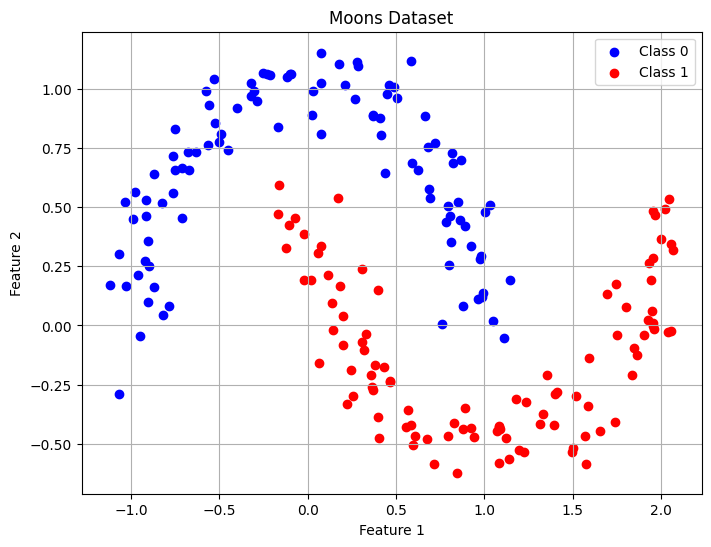

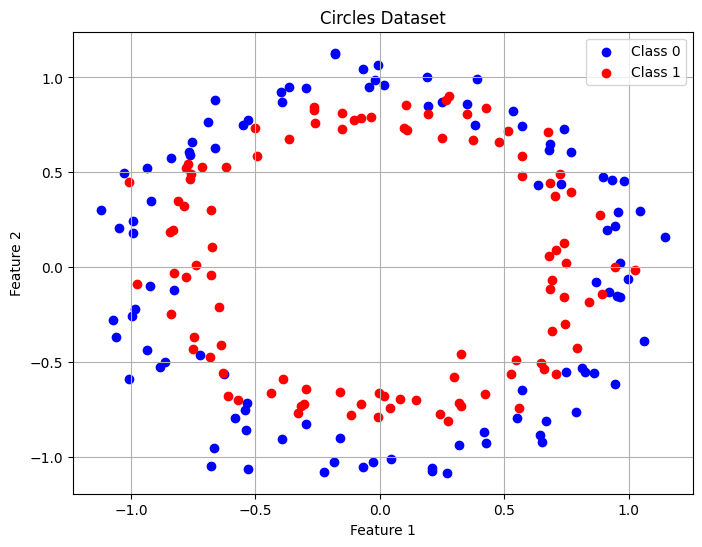

In [68]:
# create the data
X_moons, y_moons = comparison.generate_dataset('moons', n_samples=200, noise=0.1)
X_circles, y_circles = comparison.generate_dataset('circles', n_samples=200, noise=0.1)

# compare the viauslize the results for each dataset
comparison.visualize_dataset(X_moons, y_moons, "moons")
comparison.visualize_dataset(X_circles, y_circles, "circles")

### 3. Train Simple MLP

In [69]:
custom_mlp_params = {
    'hidden_layer_sizes': (5,),
    'max_iter': 2000,
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.85, 'ROC-AUC': np.float64(0.9241071428571428), 'Train Time': 0.08712005615234375}


In [71]:
custom_mlp_params = {
    'hidden_layer_sizes': (10,), 
    'max_iter': 2000, 
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.85, 'ROC-AUC': np.float64(0.9397321428571428), 'Train Time': 0.06336712837219238}


In [72]:
custom_mlp_params = {
    'hidden_layer_sizes': (20,), 
    'max_iter': 2000, 
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.9166666666666666, 'ROC-AUC': np.float64(0.96875), 'Train Time': 0.08768582344055176}


In [73]:
custom_mlp_params = {
    'hidden_layer_sizes': (50,), 
    'max_iter': 2000,
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.9666666666666667, 'ROC-AUC': np.float64(0.9966517857142857), 'Train Time': 0.21885919570922852}


In [74]:
custom_mlp_params = {
    'hidden_layer_sizes': (100,), 
    'max_iter': 2000, 
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.9666666666666667, 'ROC-AUC': np.float64(0.9988839285714286), 'Train Time': 0.23769426345825195}


In [75]:
custom_mlp_params = {
    'hidden_layer_sizes': (200,), 
    'max_iter': 2000, 
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.9666666666666667, 'ROC-AUC': np.float64(0.9988839285714286), 'Train Time': 0.23634815216064453}


In [76]:
custom_mlp_params = {
    'hidden_layer_sizes': (400,), 
    'max_iter': 2000, 
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.9666666666666667, 'ROC-AUC': np.float64(0.9988839285714286), 'Train Time': 0.313220739364624}


In [79]:
custom_mlp_params = {
    'hidden_layer_sizes': (30,), 
    'max_iter': 2000,  
    'random_state': 1
}
mlp_results = comparison.train_simple_mlp(X_moons, y_moons, mlp_params=custom_mlp_params)
print("Simple MLP on Moons Dataset:\n", mlp_results)


Simple MLP on Moons Dataset:
 {'Model': 'MLP', 'Accuracy': 0.95, 'ROC-AUC': np.float64(0.9966517857142857), 'Train Time': 0.23001503944396973}


### 4. Explain Rationale


* I used single hidden layer with 5-300 neurons to explore. The more neurons, the better the model, however it does plateau at one point. Roughly 50 were sufficient in the MLP model, providing sufficient capacity to learn non-linear patterns in simple datasets like moons and circles while keeping computational cost low.
* Default value of ReLU as the activation function in the hidden layer was efficient for training and to avoid the vanishing gradient problem
* Using the logistic sigmoid activation in the output layer is good for binary classification, as it outputs probabilities. This helped making the model compatible with evaluation metrics like ROC-AUC which was useful for me here.
* Application of k-fold cross validation was used to improve robustness and reliability of the accuracy results. This allowed performance comparison across models and noise levels to select the top candidates.

### 5. Compare SVM and MLP

In [80]:
# Train and compare models on moons dataset with noise level 0.1
df_moons_results = comparison.evaluate_and_compare(dataset_name='moons')
print("Moons Dataset Results:\n", df_moons_results)

Moons Dataset Results:
           Model  Accuracy   ROC-AUC  Train Time Dataset  Noise
0           MLP  0.883333  0.965208    0.104192   moons    0.1
1  SVM (linear)  0.850000  0.955107    0.006320   moons    0.1
2     SVM (rbf)  1.000000  1.000000    0.000808   moons    0.1
3           MLP  0.900000  0.960718    0.080908   moons    0.2
4  SVM (linear)  0.866667  0.948373    0.001035   moons    0.2
5     SVM (rbf)  0.966667  0.995511    0.000830   moons    0.2
6           MLP  0.883333  0.947250    0.070053   moons    0.3
7  SVM (linear)  0.850000  0.933782    0.001145   moons    0.3
8     SVM (rbf)  0.933333  0.978676    0.000962   moons    0.3


In [83]:
# Train and compare models on circles dataset with noise level 0.1
df_circles_results = comparison.evaluate_and_compare(dataset_name='circles')
print("Circles Dataset Results:\n", df_circles_results)

Circles Dataset Results:
           Model  Accuracy   ROC-AUC  Train Time  Dataset  Noise
0           MLP  0.483333  0.561167    0.009141  circles    0.1
1  SVM (linear)  0.450000  0.464646    0.001954  circles    0.1
2     SVM (rbf)  0.833333  0.941639    0.001953  circles    0.1
3           MLP  0.450000  0.547699    0.005161  circles    0.2
4  SVM (linear)  0.450000  0.475870    0.001365  circles    0.2
5     SVM (rbf)  0.700000  0.777778    0.001909  circles    0.2
6           MLP  0.433333  0.524130    0.006775  circles    0.3
7  SVM (linear)  0.450000  0.517396    0.001264  circles    0.3
8     SVM (rbf)  0.616667  0.693603    0.001626  circles    0.3


* Based on the results above, the SVM models train significantly faster than MLP models with RBF SVM achieving training times under 1 millisecond. We can compare this to MLP times range up to 0.1 seconds which is far longer.
* The MLP training time increases with increased noise levels, likely due to the added complexity and iterative weight updates needed
* Interestingly the SVM models are less affected by noise in training speed, showing consistent training times across different noise levels. I had not expected this, but it makes sense.
* The RBF kernel SVM consistently has the lowest computational cost compared to linear SVM and MLP. This is similar to what we saw in task 2.
* Overall, the MLP is more computationally intensive due to its iterative backpropagation process. This makes it less efficient for simple datasets like the ones above.







### 6. Apply k-Fold cross validation


In [33]:
mlp_cv_score_moons = comparison.k_fold_cross_validation(model_type="MLP", X=X_moons, y=y_moons, k=5)
print("MLP 5-Fold CV Accuracy (Moons Dataset):", mlp_cv_score_moons)


MLP 5-Fold CV Accuracy (Moons Dataset): 0.8800000000000001


In [34]:
svm_rbf_cv_score_moons = comparison.k_fold_cross_validation(model_type="SVM", X=X_moons, y=y_moons, kernel='rbf', k=5)
print("SVM (RBF) 5-Fold CV Accuracy (Moons Dataset):", svm_rbf_cv_score_moons)


SVM (RBF) 5-Fold CV Accuracy (Moons Dataset): 1.0


In [35]:
svm_linear_cv_score_moons = comparison.k_fold_cross_validation(model_type="SVM", X=X_moons, y=y_moons, kernel='linear', k=5)
print("SVM (Linear) 5-Fold CV Accuracy (Moons Dataset):", svm_linear_cv_score_moons)


SVM (Linear) 5-Fold CV Accuracy (Moons Dataset): 0.86


In [36]:
mlp_cv_score_circles = comparison.k_fold_cross_validation(model_type="MLP", X=X_circles, y=y_circles, k=5)
print("MLP 5-Fold CV Accuracy (Circles Dataset):", mlp_cv_score_circles)


MLP 5-Fold CV Accuracy (Circles Dataset): 0.495


In [37]:
svm_rbf_cv_score_circles = comparison.k_fold_cross_validation(model_type="SVM", X=X_circles, y=y_circles, kernel='rbf', k=5)
print("SVM (RBF) 5-Fold CV Accuracy (Circles Dataset):", svm_rbf_cv_score_circles)


SVM (RBF) 5-Fold CV Accuracy (Circles Dataset): 0.835


In [38]:
svm_linear_cv_score_circles = comparison.k_fold_cross_validation(model_type="SVM", X=X_circles, y=y_circles, kernel='linear', k=5)
print("SVM (Linear) 5-Fold CV Accuracy (Circles Dataset):", svm_linear_cv_score_circles)

SVM (Linear) 5-Fold CV Accuracy (Circles Dataset): 0.44000000000000006


In [39]:
df_moons_cv_results = comparison.evaluate_and_compare_with_cross_validation(dataset_name='moons', noise_levels=[0.1, 0.2, 0.3], k=5)
print("Moons Dataset Cross-Validated Model Comparison:\n", df_moons_cv_results)

Moons Dataset Cross-Validated Model Comparison:
           Model Dataset  Noise  k-Fold CV Accuracy
0           MLP   moons    0.1               0.875
1  SVM (linear)   moons    0.1               0.880
2     SVM (rbf)   moons    0.1               1.000
3           MLP   moons    0.2               0.875
4  SVM (linear)   moons    0.2               0.875
5     SVM (rbf)   moons    0.2               0.955
6           MLP   moons    0.3               0.865
7  SVM (linear)   moons    0.3               0.850
8     SVM (rbf)   moons    0.3               0.910


In [84]:
df_circles_cv_results = comparison.evaluate_and_compare_with_cross_validation(dataset_name='circles', noise_levels=[0.1, 0.2, 0.3], k=5)
print("Circles Dataset Cross-Validated Model Comparison:\n", df_circles_cv_results)

Circles Dataset Cross-Validated Model Comparison:
           Model  Dataset  Noise  k-Fold CV Accuracy
0           MLP  circles    0.1               0.480
1  SVM (linear)  circles    0.1               0.385
2     SVM (rbf)  circles    0.1               0.830
3           MLP  circles    0.2               0.475
4  SVM (linear)  circles    0.2               0.400
5     SVM (rbf)  circles    0.2               0.635
6           MLP  circles    0.3               0.445
7  SVM (linear)  circles    0.3               0.415
8     SVM (rbf)  circles    0.3               0.560


### 7. Conclusion

* In this project I designed a minimal MLP with a single hidden layer of 5-300 neurons compare the impact and to efficiently capture non-linear patterns in the moons and circles datasets.

* To maintain the requirement of "simple", I used the standard ReLU activation in the hidden layer which is a sigmoid output for binary classification. In addition, I used the Adam optimizer that the MLP was designed to learn quickly and avoid vanishing gradient issues.

* Overll SVM models particularly with the RBF kernel showed significantly faster training times than MLP across all noise levels, making SVM more computationally efficient for these tasks. We can also see this with the times that were captured above.

* k-fold cross-validation was applied for both MLP and SVM models to get more reliable accuracy estimates.


* Overall while SVM models are faster and computationally more efficient, the simple MLP provides flexibility for handling increased noise.